In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import json
import wandb
import os
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR
from skimage import color, io

In [9]:
train_json = '/kaggle/input/ayna-unet-dataset/dataset/training/data.json'
val_json = '/kaggle/input/ayna-unet-dataset/dataset/validation/data.json'

In [10]:


def extract_named_colors(json_path, base_path = '/kaggle/input/ayna-unet-dataset/dataset/training/outputs'):
    with open(json_path, 'r') as f:
        data = json.load(f)

    color_map = {}

    for item in data:
        color_name = item['colour']  # Adjust this key if necessary
        img_path = item['output_image']

        # Load image and convert to RGB
        img = Image.open(f'{base_path}/{img_path}').convert('RGB')
        img_np = np.array(img)

        # Get unique colors from the image (shape: (num_colors, 3))
        unique_colors = np.unique(img_np.reshape(-1, 3), axis=0)

        # Normalize colors (divide by 255)
        normalized_colors = (unique_colors / 255).round(3)


        norm_color_tensor = torch.tensor(normalized_colors[0].tolist())

        if color_name not in color_map:
            color_map[color_name] = norm_color_tensor
        else:
            # If a color_name already exists, you might want to verify the color is the same or update
            # Here we simply check if they match or raise a warning
            if not torch.allclose(color_map[color_name], norm_color_tensor):
                print(f"Warning: Multiple different colors found for '{color_name}'")
    
    return color_map


train_color_map = extract_named_colors(train_json)
colour_map = {}
for name, tensor_color in train_color_map.items():
    colour_map[name]= torch.tensor(tensor_color.tolist())

print("Normalized color map with names:")
colour_map

Normalized color map with names:


{'cyan': tensor([0., 1., 1.]),
 'purple': tensor([0.5020, 0.0000, 0.5020]),
 'magenta': tensor([1., 0., 1.]),
 'green': tensor([0., 1., 0.]),
 'red': tensor([1., 0., 0.]),
 'blue': tensor([0., 0., 1.]),
 'yellow': tensor([1., 1., 0.]),
 'orange': tensor([1.0000, 0.6470, 0.0000])}

In [11]:
class PolygonDataset(Dataset):
    def __init__(self, base_path,  colour_map = {}, split='training', transform=None):
        self.base_path = base_path
        self.split = split
        self.transform = transform

        with open(f"{base_path}/{split}/data.json") as f:
            self.data = json.load(f)

        #Normalised colour channels - RGB
        self.color_map = colour_map

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_img = Image.open(f"{self.base_path}/{self.split}/inputs/{item['input_polygon']}")
        input_img = input_img.convert('L')  # Convert to grayscale

        # Load output image (colored polygon)
        output_img = Image.open(f"{self.base_path}/{self.split}/outputs/{item['output_image']}")
        output_img = output_img.convert('RGB')

        # Get color tensor
        colour = self.color_map[item['colour']]

        if self.transform:
            input_img = self.transform(input_img)
            output_img = self.transform(output_img)

        return {
            'input': input_img,
            'colour': colour.float(),
            'output': output_img
        }

In [3]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Conditional_UNet(nn.Module):
    def init_weight(self, std=0.2):
        for m in self.modules():
            cn = m.__class__.__name__
            if cn.find('Conv') != -1:
                m.weight.data.normal_(0., std)
            elif cn.find('Linear') != -1:
                m.weight.data.normal_(1., std)
                m.bias.data.fill_(0)

    def __init__(self, in_ch = 1, out_ch = 3, c_embd = 1024):
        super(Conditional_UNet, self).__init__()

        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=0.3)

        # Bottleneck
        self.bottleneck = double_conv(512, c_embd)

        # Upsample
        self.up1 = nn.ConvTranspose2d(c_embd, 512, 2, stride=2)
        self.up_conv1 = double_conv(c_embd, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.up_conv2 = double_conv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up_conv3 = double_conv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up_conv4 = double_conv(128, 64)

        # Final convolution
        self.final_conv = nn.Conv2d(64, out_ch, 1)
        self.color_fc = nn.Linear(out_ch, c_embd)
        
    def forward(self, x, color, c_embd=1024):
        c1 = self.dconv_down1(x)
        p1 = self.maxpool(c1)

        c2 = self.dconv_down2(p1)
        p2 = self.maxpool(c2)
    
        c3 = self.dconv_down3(p2)
        p3 = self.maxpool(c3)
    
        c4 = self.dconv_down4(p3)
        p4 = self.maxpool(c4)
    
        # Bottleneck with color conditioning
        bottleneck = self.bottleneck(p4)
    
        # Add color information
        color_embedding = self.color_fc(color).view(-1, c_embd, 1, 1)
        bottleneck = bottleneck + color_embedding
    
        # Decode
        u1 = self.up1(bottleneck)
        u1 = torch.cat([u1, c4], dim=1)
        u1 = self.up_conv1(u1)
    
        u2 = self.up2(u1)
        u2 = torch.cat([u2, c3], dim=1)
        u2 = self.up_conv2(u2)
    
        u3 = self.up3(u2)
        u3 = torch.cat([u3, c2], dim=1)
        u3 = self.up_conv3(u3)
    
        u4 = self.up4(u3)
        u4 = torch.cat([u4, c1], dim=1)
        u4 = self.up_conv4(u4)
    
        output = self.final_conv(u4)
        return torch.sigmoid(output)

In [24]:
def validate_model(weight_path, val_loader, device='cpu', threshold=0.9, max_batches=1):
    """
    Performs inference and visualizes results from a given model weight path.
    
    Args:
        weight_path (str): Path to model weights (.pth file).
        val_loader (DataLoader): Validation data loader.
        device (torch.device): CUDA or CPU.
        threshold (float): Threshold for binarizing outputs.
        max_batches (int): Number of batches to process for visualization.
    """

    # Load model and weights
    model = Conditional_UNet(in_ch=1, out_ch=3, c_embd=1024)
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if i >= max_batches:
                break

            inputs = batch['input'].to(device)
            colors = batch['colour'].to(device)
            targets = batch['output']  # Assuming 'target' contains GT masks

            outputs = model(inputs, colors).cpu()
            targets = targets.cpu()

            # Threshold the outputs
            outputs_thresh = outputs.clone()
            outputs_thresh[outputs_thresh > 0.9] = 1.0

            # Visualize
            for j in range(outputs.shape[0]):
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))

                # Ground Truth
                gt = targets[j].permute(1, 2, 0).numpy().clip(0, 1)
                axes[0].imshow(gt)
                axes[0].set_title("Ground Truth")
                axes[0].axis('off')

                # Raw Output
                raw_output = outputs[j].permute(1, 2, 0).numpy().clip(0, 1)
                axes[1].imshow(raw_output)
                axes[1].set_title("Model Output")
                axes[1].axis('off')

                # Thresholded Output
                thresh_output = outputs_thresh[j].permute(1, 2, 0).numpy().clip(0, 1)
                axes[2].imshow(thresh_output)
                axes[2].set_title(f"Thresholded Output (> {threshold})")
                axes[2].axis('off')

                plt.tight_layout()
                plt.show()


Outputs by plain BCE model


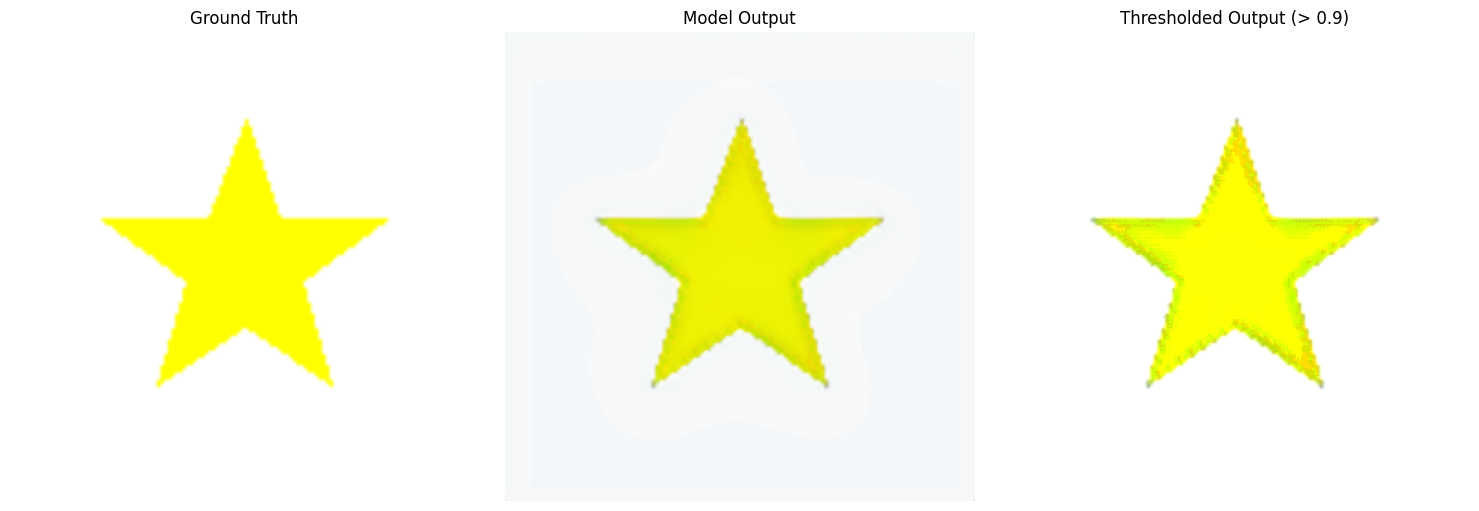

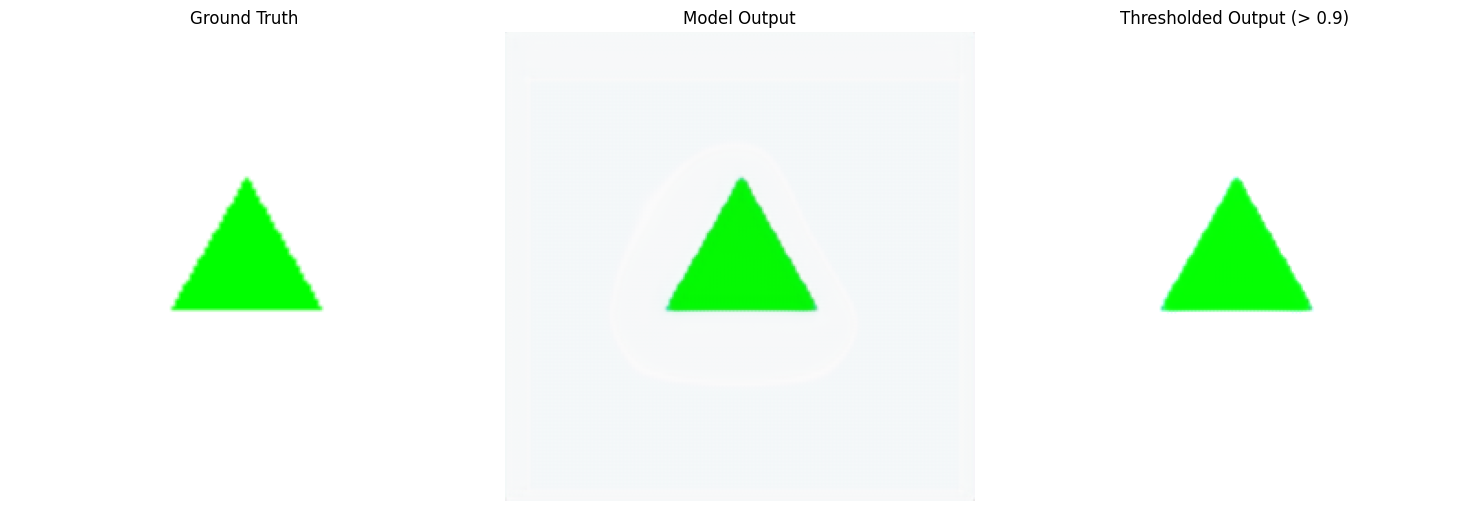

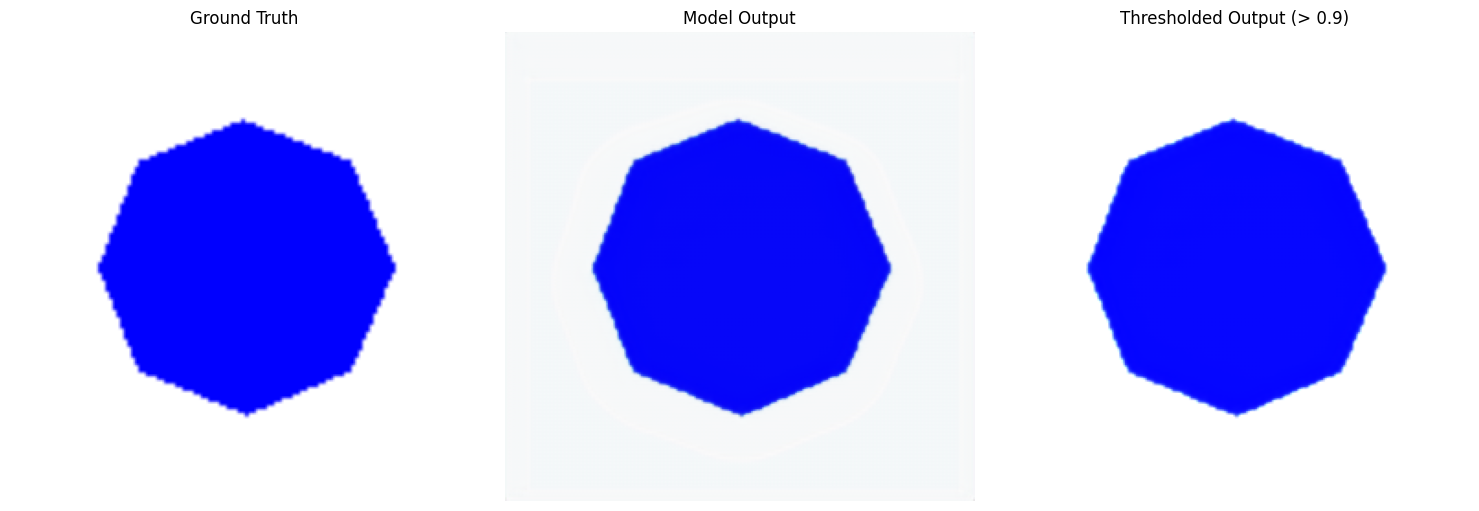

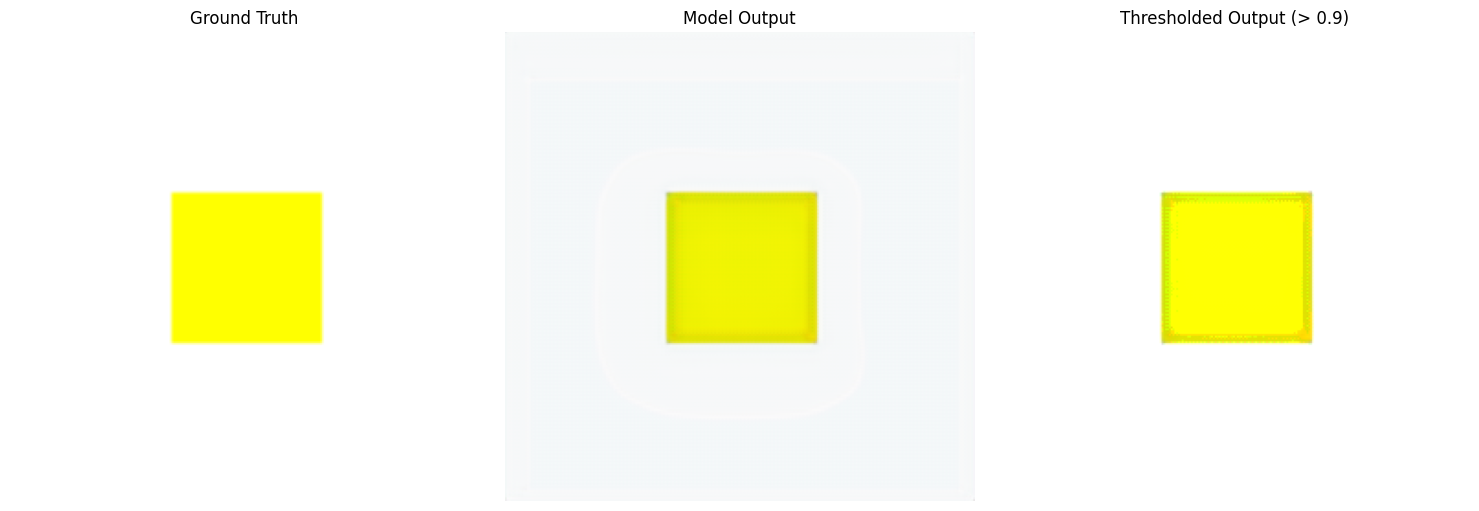

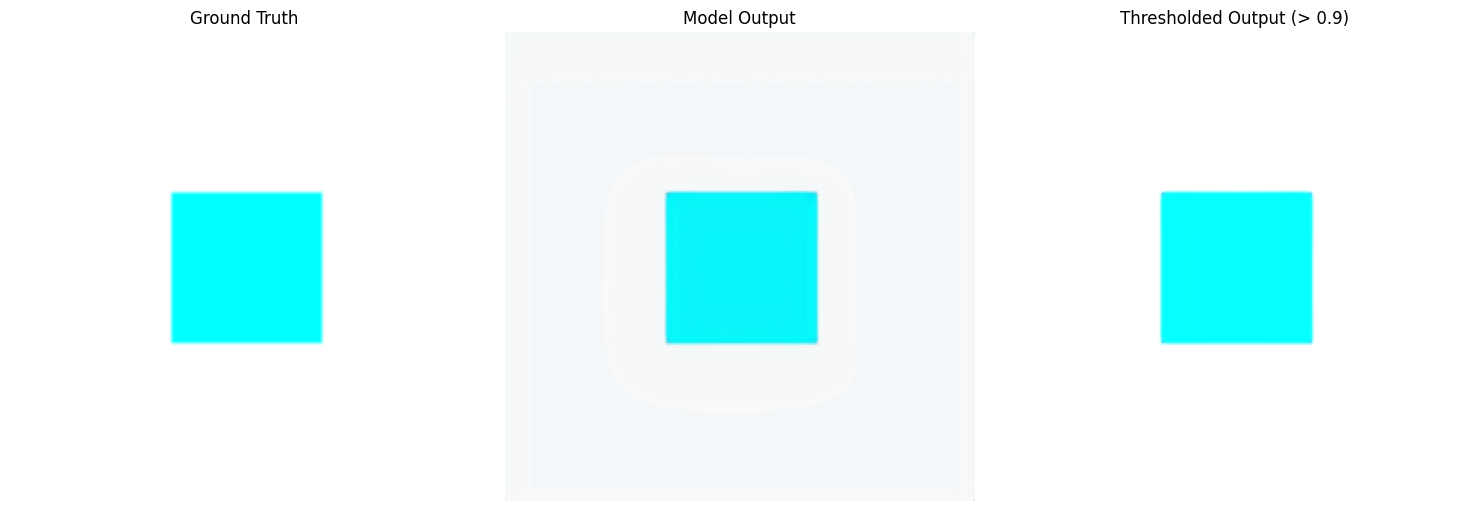

Outputs by weighted BCE model


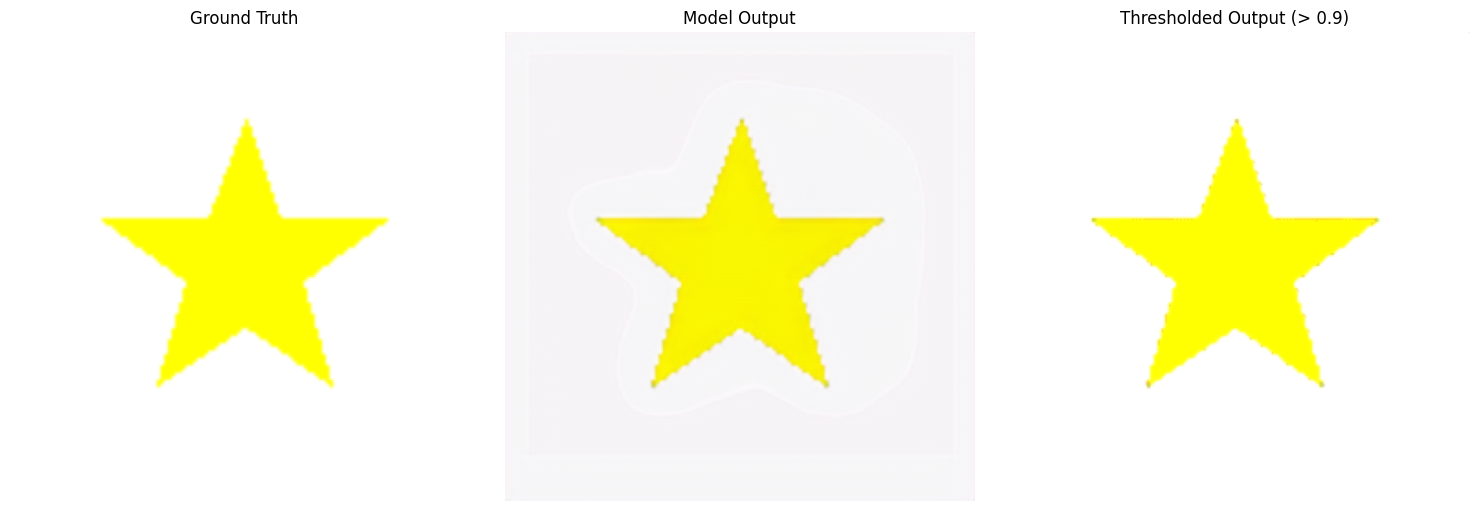

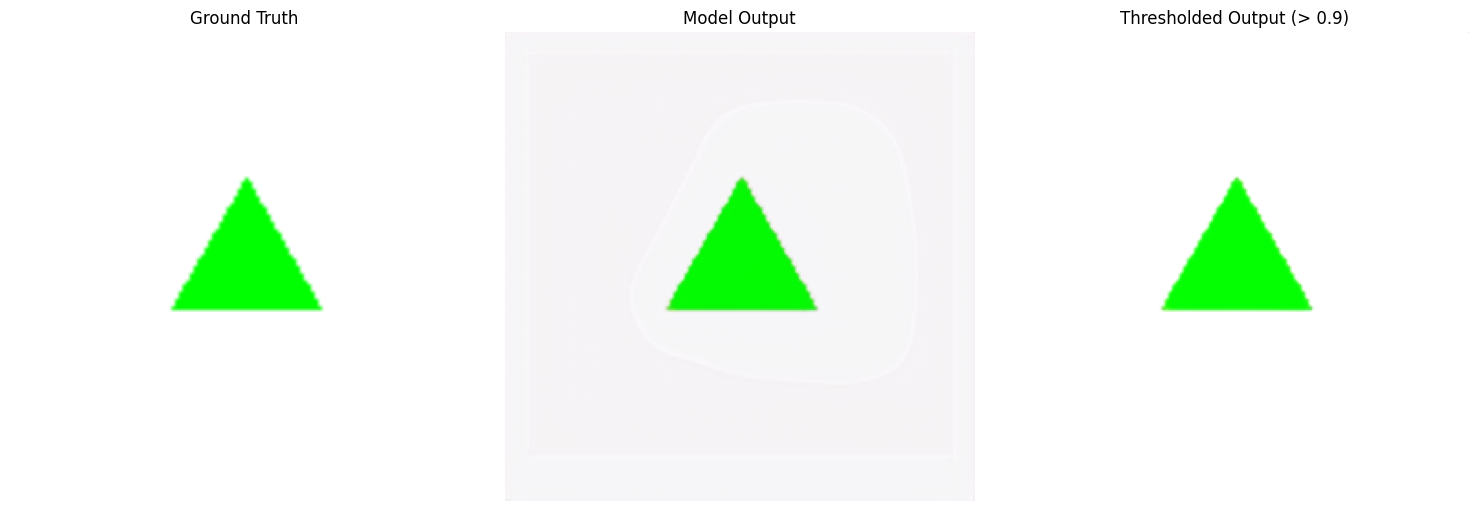

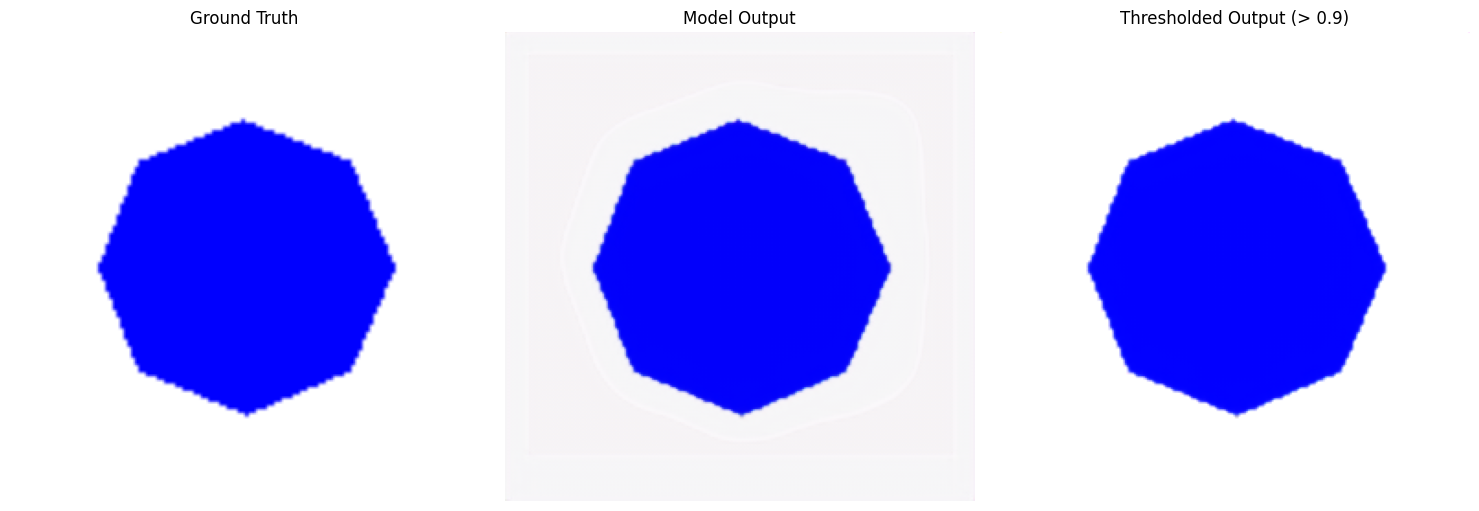

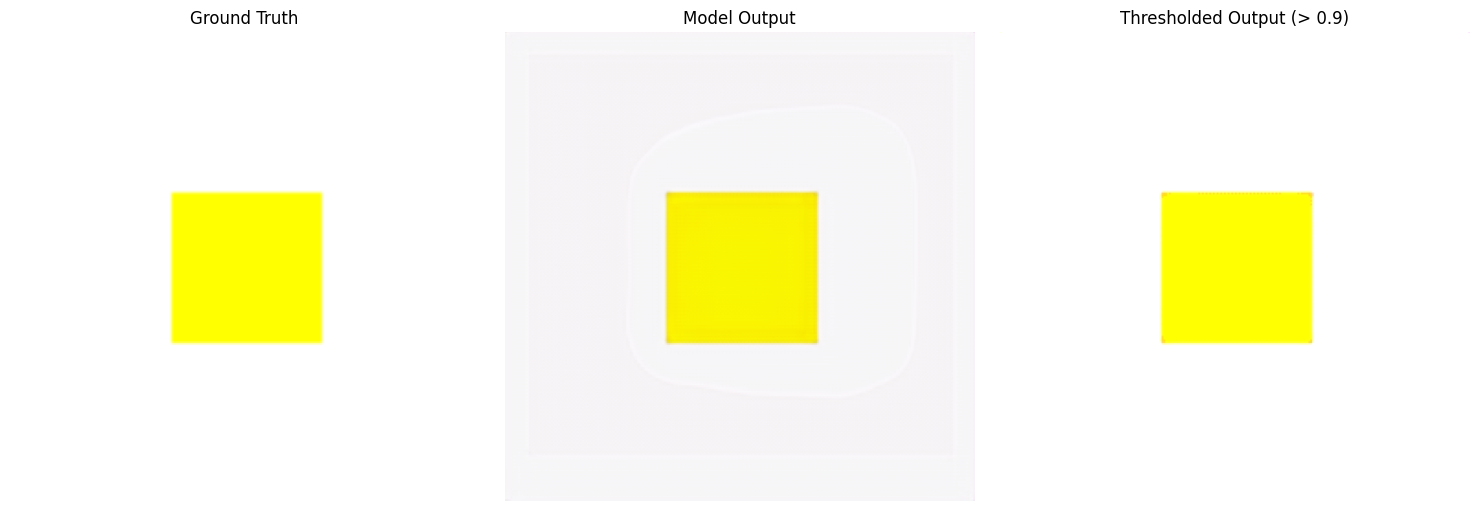

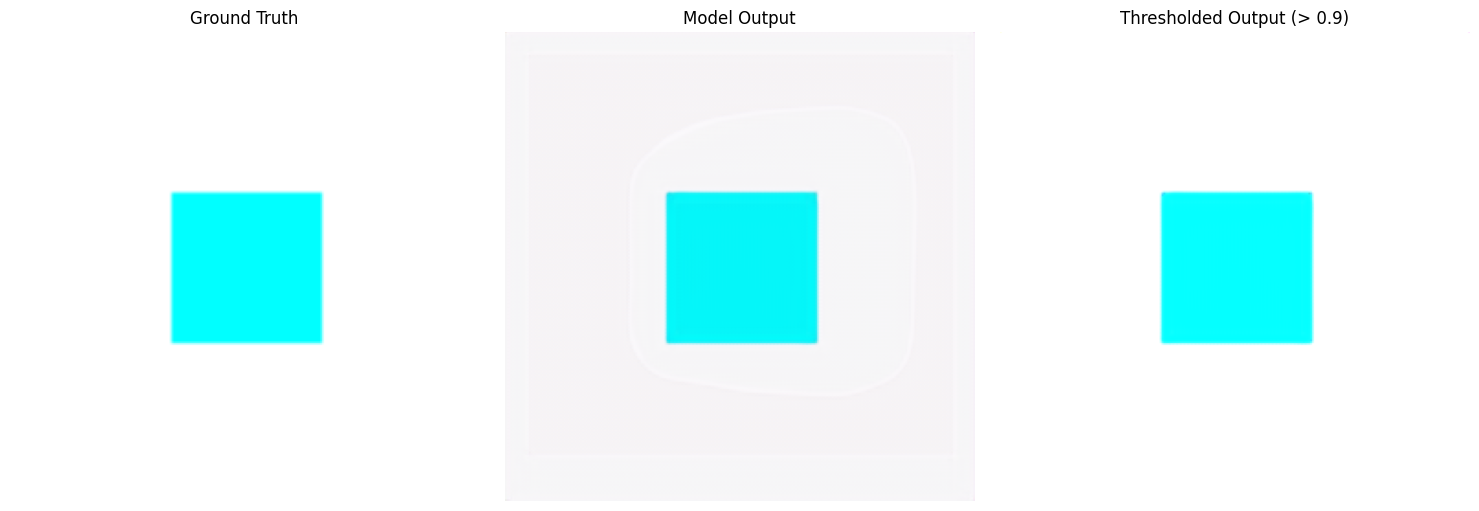

In [26]:
val_dataset = PolygonDataset(
    base_path='/kaggle/input/ayna-unet-dataset/dataset',
    colour_map=colour_map,
    split='validation',
    transform= transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor()
]))

val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)


print("Outputs by plain BCE model")
validate_model("/kaggle/input/c-unet-weights-ayna/c_unet_bce_rgb.pth", val_loader)
print("Outputs by weighted BCE model")
validate_model("/kaggle/input/c-unet-weights-ayna/c_unet_weighted_bce_rgb.pth", val_loader)
